In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [30]:
df = pd.read_csv("/Users/rickiheicklen/Github/scholars-and-sommeliers/data.csv")

In [31]:
df

,Person,Source 1,Source 2,Source 3,Source 4,Source 5,Source 6,Wine A,Wine B,Wine C,Wine D,Wine E,Wine F
0,Ricki Heicklen,4,8,9,6,1,11.0,4,6,10.0,5.0,6.0,7.0
1,Joe Blumberg,4,4,7,7,8,11.0,4,6,1.0,-1.0,5.0,1.0
2,Daniel Peled-Schwartz,5,-1,10,3,7,5.0,5,5,3.0,1.0,6.0,-1.0
3,Avital Morris,8,4,4,3,10,9.0,5,4,4.0,1.0,1.0,2.0
4,Chana Fisch,5,3,10,4,5,10.0,3,2,NaN,NaN,NaN,NaN
5,Jen Greenberg,1,1,1,1,5,10.0,8,4,10.0,3.0,2.0,1.0
6,Jasmine Peled-Schwartz,2,5,5,5,4,10.0,3,6,10.0,4.0,6.0,1.0
7,Ronit Morris,6,1,7,2,5,10.0,1,3,1.0,1.0,2.0,1.0
8,Susan Palefsky,2,3,4,3,4,5.0,3,2,5.0,-1.0,5.0,1.0
9,Tadhg Cleary,7,2,4,10,5,10.0,7,5,8.0,3.0,1.0,1.0


### scrap from ChatGPT

In [19]:
import pandas as pd

data = {
    'Student': ['Alice', 'Bob', 'Charlie'],
        'Color': ['red', 'yellow', 'blue'],
    'Study Hours': [[0, 1, 2, 3], [4, 5, 6], [7, 8, 9, 10]],
    'Test Scores': [[10, 20, 30, 40], [50, 60, 70], [80, 90, 100, 110]]
}

df = pd.DataFrame(data)
df

,Student,Color,Study Hours,Test Scores
0,Alice,red,"[0, 1, 2, 3]","[10, 20, 30, 40]"
1,Bob,yellow,"[4, 5, 6]","[50, 60, 70]"
2,Charlie,blue,"[7, 8, 9, 10]","[80, 90, 100, 110]"


In [23]:

# Flatten the 'Study Hours' and 'Test Scores' columns
df['Study Hours'] = df['Study Hours'].apply(lambda x: x[0])
df['Test Scores'] = df['Test Scores'].apply(lambda x: x[0])

# Create the scatter plot
# plt.scatter(df['Study Hours'], df['Test Scores'], c=df['Student'])

TypeError: 'int' object is not subscriptable

ValueError: setting an array element with a sequence.

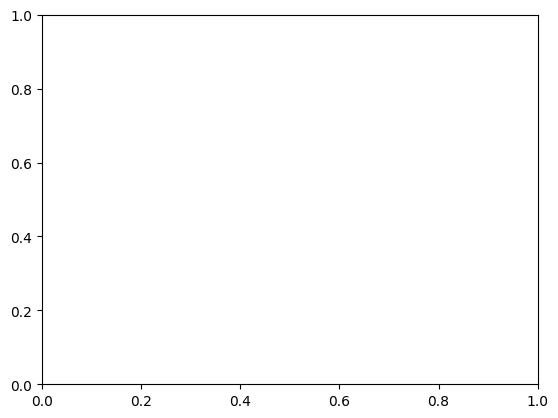

In [21]:
colors = ['red', 'blue', 'green']

# Create the scatter plot
plt.scatter(df['Study Hours'], df['Test Scores'], c=colors)


In [28]:
## Attempt at graphing rishonim

## Attempt at graphing rishonim

In [29]:
df

,Student,Color,Study Hours,Test Scores
0,Alice,red,0,10
1,Bob,yellow,4,50
2,Charlie,blue,7,80


In [24]:
data = {
    'Alice': [[0, 1, 2, 3], [10, 20, 30, 40]],
    'Bob': [[4, 5, 6], [50, 60, 70]],
    'Charlie': [[7, 8, 9, 10], [80, 90, 100, 110]]
}

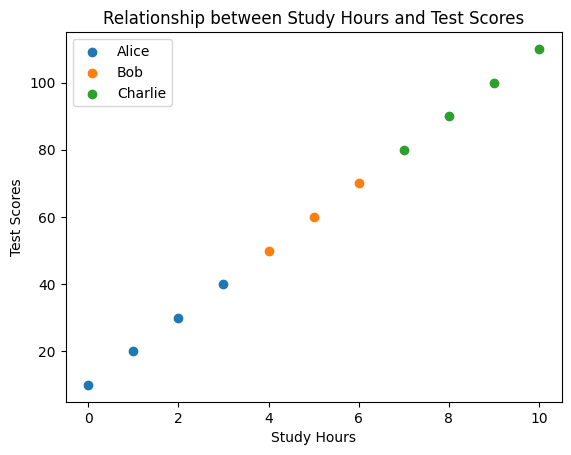

In [27]:
# Loop through the data and plot each student's data
for student, (study_hours, test_scores) in data.items():
    plt.scatter(study_hours, test_scores, label=student)

# Add labels and title
plt.xlabel('Study Hours')
plt.ylabel('Test Scores')
plt.title('Relationship between Study Hours and Test Scores')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [32]:
# Wines:
# Abarbanel, Bartenura, Alfasi, Sforno, Rashi, Schwartz

# Wines: 
# Alfasi, Abarbanel, Bartenura, Rashi, Sforno, Schwartz

,Person,Source 1,Source 2,Source 3,Source 4,Source 5,Source 6,Wine A,Wine B,Wine C,Wine D,Wine E,Wine F
0,Ricki Heicklen,4,8,9,6,1,11.0,4,6,10.0,5.0,6.0,7.0
1,Joe Blumberg,4,4,7,7,8,11.0,4,6,1.0,-1.0,5.0,1.0
2,Daniel Peled-Schwartz,5,-1,10,3,7,5.0,5,5,3.0,1.0,6.0,-1.0
3,Avital Morris,8,4,4,3,10,9.0,5,4,4.0,1.0,1.0,2.0
4,Chana Fisch,5,3,10,4,5,10.0,3,2,NaN,NaN,NaN,NaN
5,Jen Greenberg,1,1,1,1,5,10.0,8,4,10.0,3.0,2.0,1.0
6,Jasmine Peled-Schwartz,2,5,5,5,4,10.0,3,6,10.0,4.0,6.0,1.0
7,Ronit Morris,6,1,7,2,5,10.0,1,3,1.0,1.0,2.0,1.0
8,Susan Palefsky,2,3,4,3,4,5.0,3,2,5.0,-1.0,5.0,1.0
9,Tadhg Cleary,7,2,4,10,5,10.0,7,5,8.0,3.0,1.0,1.0


In [ ]:
                'Wine 1': 'Alfasi (Wine)', 
                   'Wine 2': 'Abarbanel (Wine)',
                   'Wine 3': 'Bartenura (Wine)',
                   'Wine 4': 'Rashi (Wine)',
                   'Wine 5': 'Sforno (Wine)',
                   'Wine 6': 'Schwartz (Wine)',

In [ ]:
'Source 1': 'Abarbanel (Source)', 
                   'Source 2': 'Bartenura (Source)',
                   'Source 3': 'Alfasi (Source)',
                   'Source 4': 'Sforno (Source)',
                   'Source 5': 'Rashi (Source)',
                   'Source 6': 'Schwartz (Source)',

In [36]:
df.rename(columns={'Source 1': 'Abarbanel (Source)', 
                   'Source 2': 'Bartenura (Source)',
                   'Source 3': 'Alfasi (Source)',
                   'Source 4': 'Sforno (Source)',
                   'Source 5': 'Rashi (Source)',
                   'Source 6': 'Schwartz (Source)',
                   'Wine A': 'Alfasi (Wine)', 
                   'Wine B': 'Abarbanel (Wine)',
                   'Wine C': 'Bartenura (Wine)',
                   'Wine D': 'Rashi (Wine)',
                   'Wine E': 'Sforno (Wine)',
                   'Wine F': 'Schwartz (Wine)'
                   },
                   inplace=True)

In [37]:
df

,Person,Abarbanel (Source),Bartenura (Source),Alfasi (Source),Sforno (Source),Rashi (Source),Schwartz (Source),Alfasi (Wine),Abarbanel (Wine),Bartenura (Wine),Rashi (Wine),Sforno (Wine),Schwartz (Wine)
0,Ricki Heicklen,4,8,9,6,1,11.0,4,6,10.0,5.0,6.0,7.0
1,Joe Blumberg,4,4,7,7,8,11.0,4,6,1.0,-1.0,5.0,1.0
2,Daniel Peled-Schwartz,5,-1,10,3,7,5.0,5,5,3.0,1.0,6.0,-1.0
3,Avital Morris,8,4,4,3,10,9.0,5,4,4.0,1.0,1.0,2.0
4,Chana Fisch,5,3,10,4,5,10.0,3,2,NaN,NaN,NaN,NaN
5,Jen Greenberg,1,1,1,1,5,10.0,8,4,10.0,3.0,2.0,1.0
6,Jasmine Peled-Schwartz,2,5,5,5,4,10.0,3,6,10.0,4.0,6.0,1.0
7,Ronit Morris,6,1,7,2,5,10.0,1,3,1.0,1.0,2.0,1.0
8,Susan Palefsky,2,3,4,3,4,5.0,3,2,5.0,-1.0,5.0,1.0
9,Tadhg Cleary,7,2,4,10,5,10.0,7,5,8.0,3.0,1.0,1.0
